### MARIO FERNANDEZ BUSTO
### JUAN JOSE JIMENEZ DE JUAN
### JORGE CHAMORRO PEDROSA

Best number of clusters according to Silhouette: k = 9


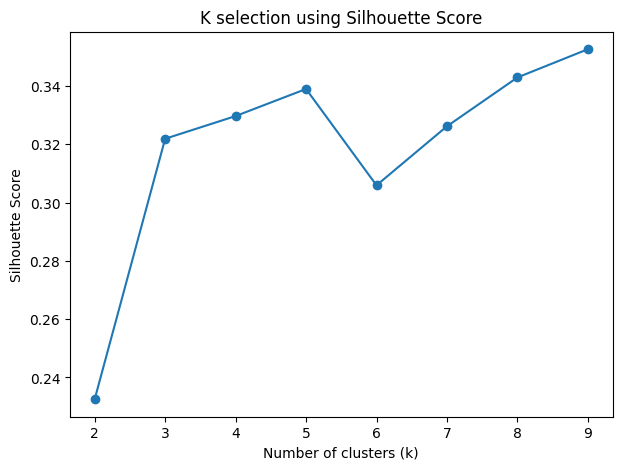

          F0_mean    F0_std  F0_count  F1_log_mean  F1_log_std  F1_log_count  \
cluster                                                                        
0        0.426829  0.496132       164     0.305828    0.090649           164   
1        0.000000  0.000000        93     0.368967    0.077524            93   
2        1.000000  0.000000       260     0.402445    0.105254           260   
3        0.619048  0.488538        84     0.335487    0.091829            84   
4        0.000000  0.000000       146     0.408386    0.114518           146   
5        0.717391  0.452735        92     0.196733    0.069530            92   
6        1.000000  0.000000       162     0.360846    0.076570           162   
7        0.750000  0.444262        20     0.363318    0.064465            20   
8        0.692308  0.464095        91     0.292061    0.075638            91   

         F2_mean    F2_std  F2_count   F3_mean  ...  F4_count   F5_mean  \
cluster                                     

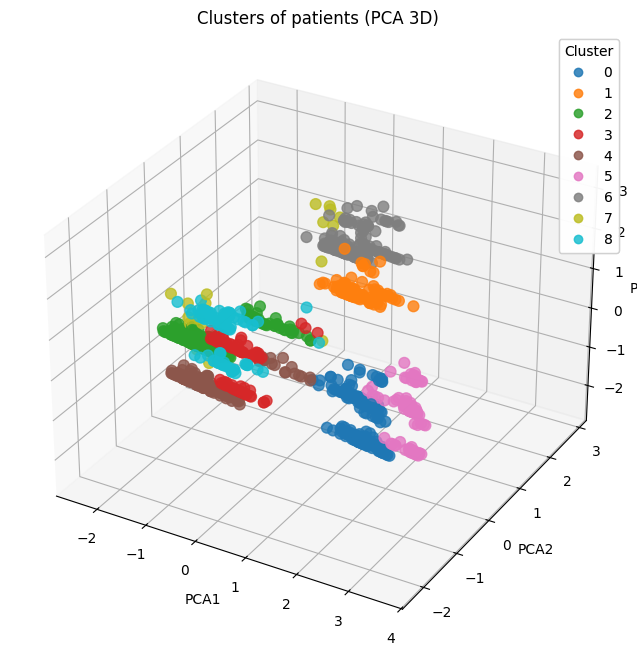

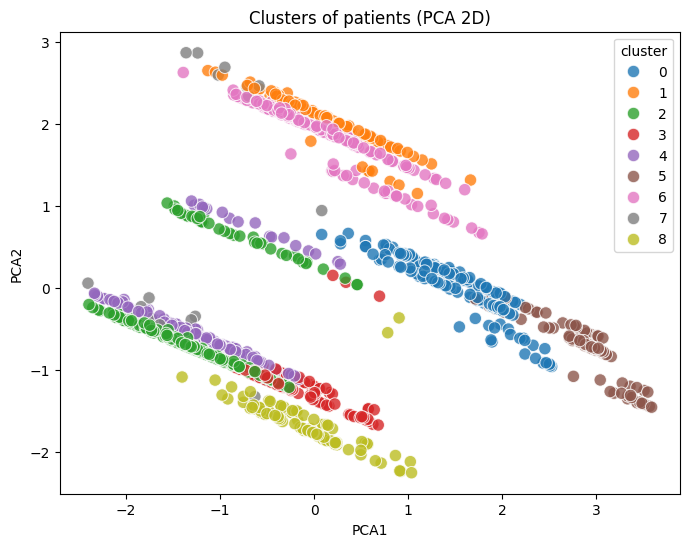

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


# Load the datasets
df_features = pd.read_csv('features.csv', sep=';')  # ID, F0-F7
df_timelines = pd.read_csv('timelines.csv', sep=';')  # ID, time_1-time_11

# Preprocessing of the data
## Log-transform F1
df_features['F1_log'] = np.log1p(df_features['F1'])

# Scale all numeric features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_features[['F0','F1_log','F2','F3','F4','F5','F6','F7']])
X = pd.DataFrame(features_scaled, columns=['F0','F1_log','F2','F3','F4','F5','F6','F7'])

# Select best k using Silhouette Score
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
    labels = kmeans.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

## Best k value
k_opt = K_range[np.argmax(sil_scores)]
print(f"Best number of clusters according to Silhouette: k = {k_opt}")

## Plot Silhouette scores
plt.figure(figsize=(7,5))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K selection using Silhouette Score')
plt.show()

# Final clustering with optimal k
kmeans_final = KMeans(n_clusters=k_opt, random_state=42, n_init=50)
df_features['cluster'] = kmeans_final.fit_predict(X)

# Cluster profiling
cluster_profile = df_features.groupby('cluster')[['F0','F1_log','F2','F3','F4','F5','F6','F7']].agg(['mean','std','count'])
cluster_profile.columns = ['_'.join(col).strip() for col in cluster_profile.columns.values]
print(cluster_profile)

# PCA 3D visualization
pca3 = PCA(n_components=3, random_state=42)
X_pca3 = pca3.fit_transform(X)
df_plot3 = pd.DataFrame(X_pca3, columns=['PCA1','PCA2','PCA3'])
df_plot3['cluster'] = df_features['cluster']

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_plot3['PCA1'], df_plot3['PCA2'], df_plot3['PCA3'],
                     c=df_plot3['cluster'], cmap='tab10', s=60, alpha=0.8)
ax.set_xlabel('PCA1'); ax.set_ylabel('PCA2'); ax.set_zlabel('PCA3')
ax.set_title('Clusters of patients (PCA 3D)')
legend1 = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend1)
plt.show()

# PCA 2D optional
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X)
df_plot2 = pd.DataFrame(X_pca2, columns=['PCA1','PCA2'])
df_plot2['cluster'] = df_features['cluster']

plt.figure(figsize=(8,6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', palette='tab10',
                data=df_plot2, s=80, alpha=0.8)
plt.title('Clusters of patients (PCA 2D)')
plt.show()

In [3]:
# Preprocessing of timelines
df = df_timelines.merge(df_features[['ID','cluster']], on='ID')
time_cols = [col for col in df_timelines.columns if col.startswith('time_')]

def process_patient_times(row):
    times = row[time_cols].values.astype(float)
    times = times[times > 0]  # remover ceros
    if len(times) == 0:
        return None
    # transform relative times to absolute times
    cumulative = np.cumsum(times)
    cumulative = np.append(cumulative, cumulative[-1]+1)  # end of the process
    return cumulative

df['event_times'] = df.apply(process_patient_times, axis=1)
df = df.dropna(subset=['event_times'])


# Adjust Hawkes process per cluster
from HawkesPyLib.inference import ExpHawkesProcessInference

results = []

for cluster_id in sorted(df['cluster'].unique()):
    all_events = df.loc[df['cluster']==cluster_id, 'event_times'].tolist()

    # Ignore small clusters
    if len(all_events) < 10:
        print(f"Cluster {cluster_id} too small, skipping.")
        continue
    
    # concatenate all event times
    timestamps = np.sort(np.concatenate(all_events))
    T = timestamps[-1]  # process end time

    hawkes = ExpHawkesProcessInference()
    try:
        # Robust fitting with reasonable initial parameters
        hawkes.estimate_grid(
            timestamps, T=T, grid_size=50,
            custom_param_vec0=True,
            param_vec0=np.array([0.5, 0.1, 0.1])  # [mu0, eta0, theta0] initial values
        )
        mu, eta, theta = hawkes.get_params()
        logL = hawkes.logL
    except Exception as e:
        mu, eta, theta, logL = [np.nan]*4
        print(f"Error cluster {cluster_id}: {e}")

    results.append({
        'cluster': cluster_id,
        'mu': mu,
        'eta': eta,
        'theta': theta,
        'logL': logL,
        'n_patients': len(all_events),
        'n_events': len(timestamps)
    })

df_hawkes = pd.DataFrame(results)
df_hawkes = df_hawkes.sort_values('cluster').reset_index(drop=True)

print("Hawkes parameters by cluster:")
print(df_hawkes)

Hawkes parameters by cluster:
   cluster         mu       eta         theta        logL  n_patients  \
0        0  12.611108  0.055046  1.000000e-10  547.172799          70   
1        1  10.099302  0.019048  1.000000e-10  172.626573          35   
2        2  25.518257  0.027439  1.000000e-10  883.169827         103   
3        3  11.029537  0.012500  1.000000e-10  129.689968          26   
4        4   9.041131  0.025424  1.000000e-10  194.468308          45   
5        5   3.469859  0.708059  3.539782e-01  193.697907          33   
6        6  17.045748  0.015625  1.000000e-10  402.422045          65   
7        7   4.536341  0.603323  1.572591e-01  156.160743          17   
8        8   4.370391  0.422759  1.388809e-01   75.367750          22   

   n_events  
0       219  
1       106  
2       329  
3        81  
4       119  
5       125  
6       193  
7       101  
8        69  


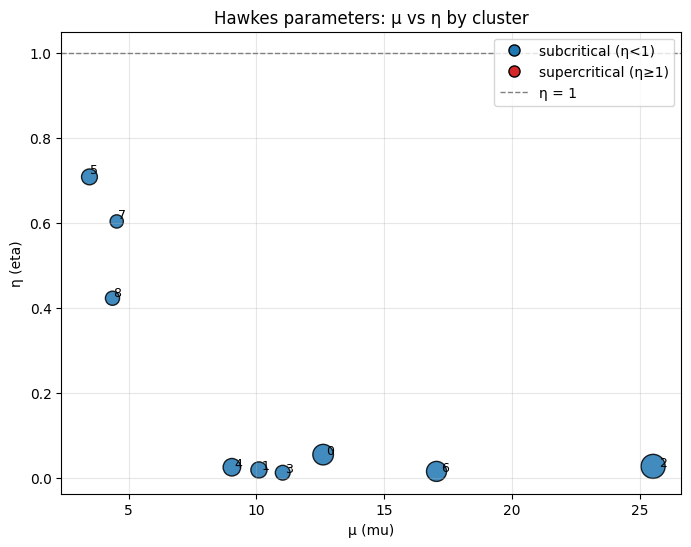

In [ ]:
# Scatter plot of mu vs eta
df_plot = df_hawkes.copy()

if df_plot.empty:
    print("No Hawkes parameters available to plot.")
else:
    # classify clusters by eta (branching ratio)
    df_plot['type'] = np.where(df_plot['eta'] >= 1.0, 'supercritical (η≥1)', 'subcritical (η<1)')

    # marker size proportional to number of patients in the cluster
    sizes = 50 + 250 * (df_plot['n_patients'] / df_plot['n_patients'].max())

    plt.figure(figsize=(8,6))
    colors = df_plot['type'].map({'subcritical (η<1)': 'tab:blue', 'supercritical (η≥1)': 'tab:red'})
    plt.scatter(df_plot['mu'], df_plot['eta'], c=colors, s=sizes, alpha=0.85, edgecolor='k')

    # annotate cluster ids
    for _, row in df_plot.iterrows():
        plt.text(row['mu']*1.01, row['eta']*1.01, str(int(row['cluster'])), fontsize=9)

    # reference line at eta = 1 (critical)
    plt.axhline(1.0, color='gray', linestyle='--', linewidth=1, label='η = 1 (critical)')

    plt.xlabel('μ (mu)')
    plt.ylabel('η (eta)')
    plt.title('Hawkes parameters: μ vs η by cluster')
    from matplotlib.lines import Line2D
    legend_elems = [
        Line2D([0],[0], marker='o', color='w', label='subcritical (η<1)', markerfacecolor='tab:blue', markersize=8, markeredgecolor='k'),
        Line2D([0],[0], marker='o', color='w', label='supercritical (η≥1)', markerfacecolor='tab:red', markersize=8, markeredgecolor='k'),
        Line2D([0],[0], color='gray', lw=1, linestyle='--', label='η = 1')
    ]
    plt.legend(handles=legend_elems, loc='upper right')
    plt.grid(alpha=0.3)
    plt.show()